## Objective
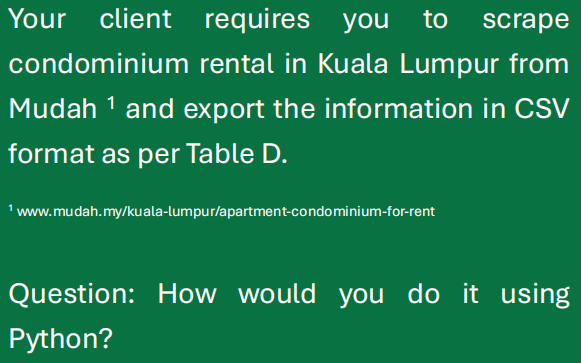

## Expected Output
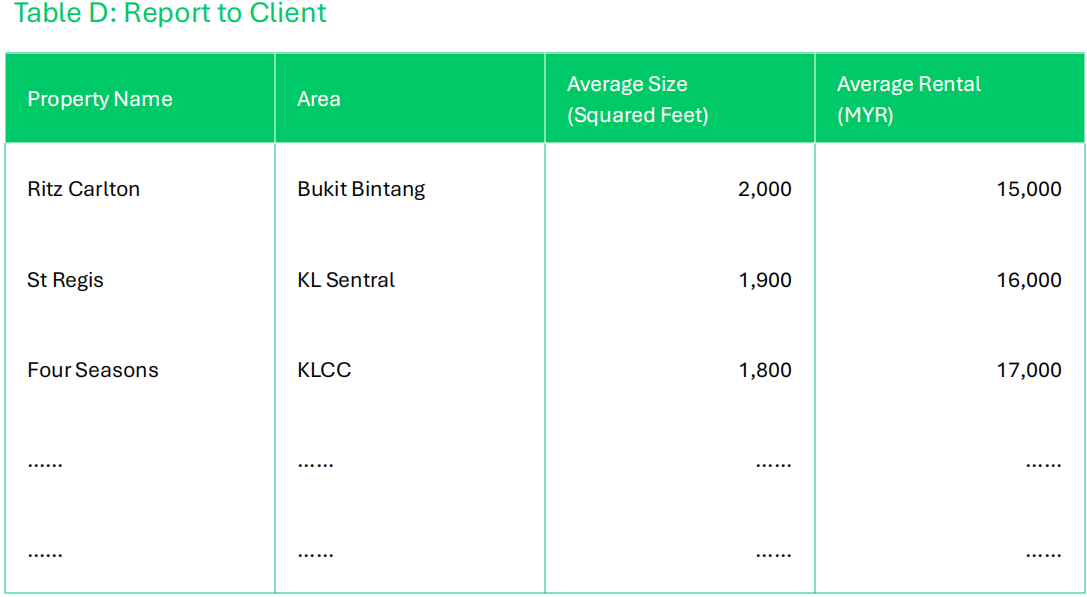

## Libraries

In [110]:
import json
import re
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display

from playwright.async_api import async_playwright
import asyncio

import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Playwright
- https://github.com/oxylabs/playwright-web-scraping

## HTML
> 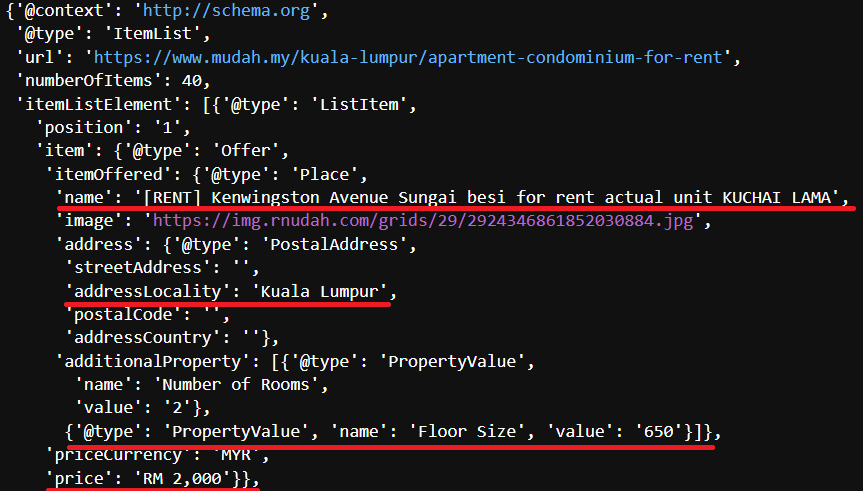

In [5]:
# !pip install playwright pandas
# !playwright install

In [9]:
async def main():
    async with async_playwright() as pw:
        browser = await pw.chromium.launch(headless=False)
        page = await browser.new_page(user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36")

        print("Navigating to Mudah.my...")
        await page.goto("https://www.mudah.my/kuala-lumpur/apartment-condominium-for-rent", timeout=60000)

        print("Scrolling to bottom...")
        await page.evaluate("""() => {
            window.scrollTo(0, document.body.scrollHeight);
        }""")

        await page.wait_for_timeout(5000)  # wait for listings to load

        print("Taking screenshot...")
        await page.screenshot(path="../Python/Input/mudah_scroll_debug.png", full_page=True)

        print("Saving HTML...")
        html_content = await page.content()
        with open("../Python/Input/mudah_page_dump.html", "w", encoding="utf-8") as f:
            f.write(html_content)

        await browser.close()
        print("Done.")

# Run the function
await main()

Navigating to Mudah.my...
Scrolling to bottom...
Taking screenshot...
Saving HTML...
Done.


## BeautifulSoup

In [344]:
# Load the HTML file
with open("../Python/Input/mudah_page_dump.html", "r", encoding="utf-8") as f:
    html = f.read()

# Parse the HTML
soup = BeautifulSoup(html, "html.parser")

# Find relevent "blocks"
script_tags = soup.find_all("script", type="application/ld+json")
listings = []

# Extract the 'ItemList' block
for tag in script_tags:
    try:
        data = json.loads(tag.string)
        if isinstance(data, list):
            for obj in data:
                if obj.get("@type") == "ItemList":
                    listings = obj["itemListElement"]
    except Exception:
        continue

# Area keywords to extract area from title
area_keywords = [
    "Ampang", "Bangsar", "Brickfields", "Bukit Bintang", "Bukit Jalil", "Cheras",
    "Desa ParkCity", "Dutamas", "KL Sentral", "KLCC", "Kepong", "Kuchai Lama",
    "Mid Valley", "Mont Kiara", "Old Klang Road", "Segambut", "Sentul", "Seputeh",
    "Setapak", "Setiawangsa", "Sri Hartamas", "Taman Desa", "Taman Melati",
    "Titiwangsa", "Wangsa Maju"
]

# Extract all listing info
results = []
for item in listings:
    try:
        offer = item["item"]
        place = offer["itemOffered"]

        # Property name & location
        raw_name = place.get("name", "").strip()
        area = next((a for a in area_keywords if a.lower() in raw_name.lower()), "Kuala Lumpur")

        # Rental prize & floor size
        raw_price = offer.get("price", "")
        floor = place.get("additionalProperty", "")[1]
        floor_size = floor.get("value","")       

        results.append({
            "Property Name": raw_name,
            "Location": area,
            "Rental": raw_price,
            "Size": floor_size
            })
        
    except Exception:
        continue

# Save and show extracted data
df = pd.DataFrame(results)
# display(df)

## Pandas

In [347]:
# Fix rental price & floor size
df['Rental'] = df['Rental'].apply(lambda x: x.split()[1].replace(",",""))
df = df.astype({'Rental':int, 'Size':int})

# Group by location
df_kl = df[df.Location != 'Kuala Lumpur'][['Location', 'Rental', 'Size']]
df_kl = df_kl.groupby(['Location'])[['Rental', 'Size']].mean().reset_index()
df_kl = df_kl.sort_values(by=['Rental'], ascending=False)

df.info()
display(df_kl)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Property Name  40 non-null     object
 1   Location       40 non-null     object
 2   Rental         40 non-null     int32 
 3   Size           40 non-null     int32 
dtypes: int32(2), object(2)
memory usage: 1.1+ KB


,Location,Rental,Size
1,Brickfields,3550.000000,914.500000
3,Cheras,2400.000000,954.500000
0,Ampang,2250.000000,533.000000
6,Kuchai Lama,2200.000000,1063.000000
4,KL Sentral,2000.000000,775.000000
2,Bukit Jalil,1771.428571,981.428571
8,Sentul,1749.500000,836.000000
9,Setapak,1616.666667,1016.666667
5,Kepong,1600.000000,1321.500000
7,Old Klang Road,1583.333333,665.666667


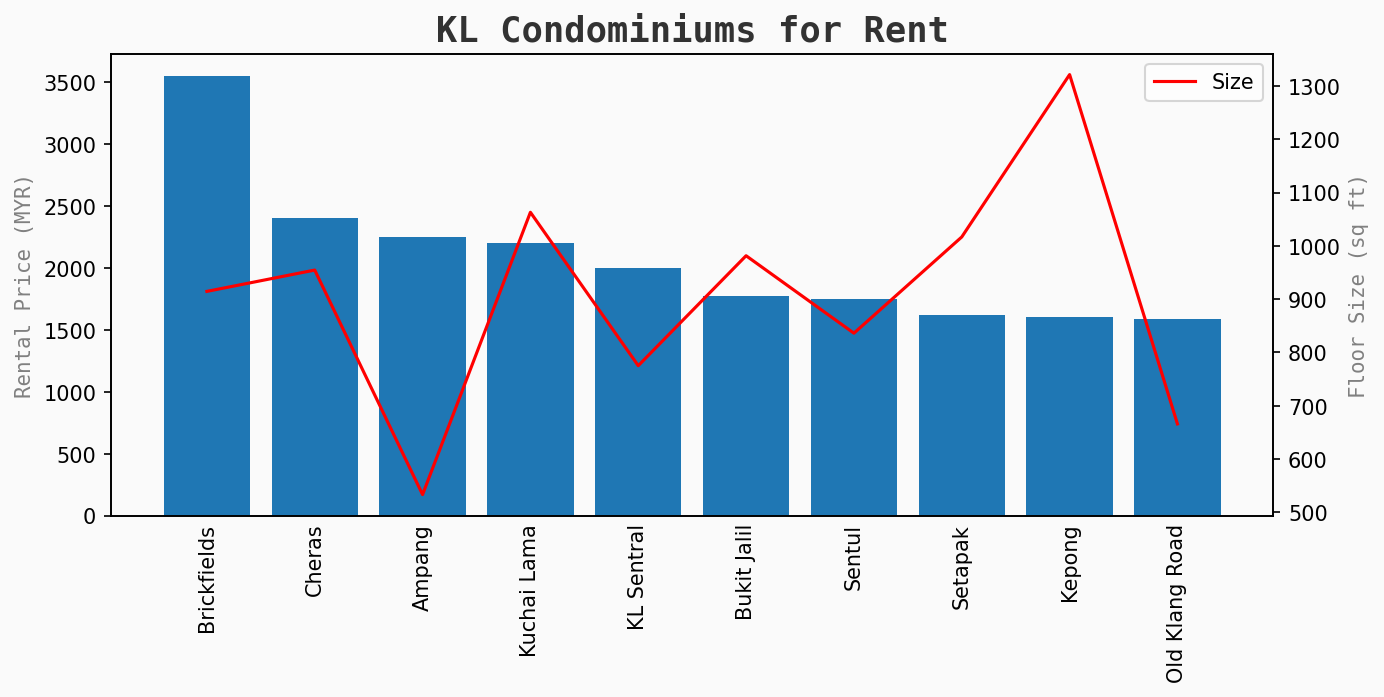

In [391]:
# Plot
background_color = "#fafafa"

fig = plt.figure(figsize=(10, 4), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

ax0.bar(df_kl['Location'],df_kl['Rental'])
ax0.tick_params(axis='x', which='both', length=0)
# for s in ["left","bottom","right", "top"]:
#     ax0.spines[s].set_visible(False)
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90)
ax0.set_ylabel("Rental Price (MYR)",fontfamily='monospace',color='gray')
# ax0.legend(['Prize'])

ax0 = plt.twinx()
ax0.plot(df_kl['Location'],df_kl['Size'], color='r')
ax0.legend(['Size'])
ax0.set_ylabel("Floor Size (sq ft)",fontfamily='monospace',color='gray')
plt.title('KL Condominiums for Rent', fontdict={'fontfamily':'monospace','fontsize':17,'weight':'bold','color':'#323232'})
# for s in ["left","bottom","right", "top"]:
#     ax0.spines[s].set_visible(False)

plt.savefig('../Python/Input/mudah_output.png', bbox_inches='tight')
plt.show()